In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 15]
plt.style.use("ggplot")

In [3]:
filePath = '../data/processed/final_features.csv'
df = pd.read_csv(filePath, index_col='Time', parse_dates=True)

In [4]:
df.head()

,fuelConsumption,HFO,shaftSpeed,speedWater,heading,rudderAngle,TWS,TWD,temp,meanDraft
Time,,,,,,,,,,
2017-07-06 13:15:00,0.0,0.0,84.878837,15.607449,167.741687,358.025169,6.675341,314.224434,20.283071,2.874424
2017-07-06 14:00:00,0.0,0.0,84.868300,15.776289,168.034239,357.967447,7.034934,308.615477,20.360865,2.877338
2017-07-06 15:00:00,0.0,0.0,84.874972,15.707046,152.496507,358.605730,7.778714,303.563221,20.534437,2.882920
2017-07-06 16:00:00,0.0,0.0,84.867446,15.723442,128.601049,358.864694,8.508143,300.737464,20.641539,2.886406
2017-07-06 17:00:00,0.0,0.0,84.864535,15.692471,107.945165,358.951153,8.541664,302.903406,20.662176,2.887449


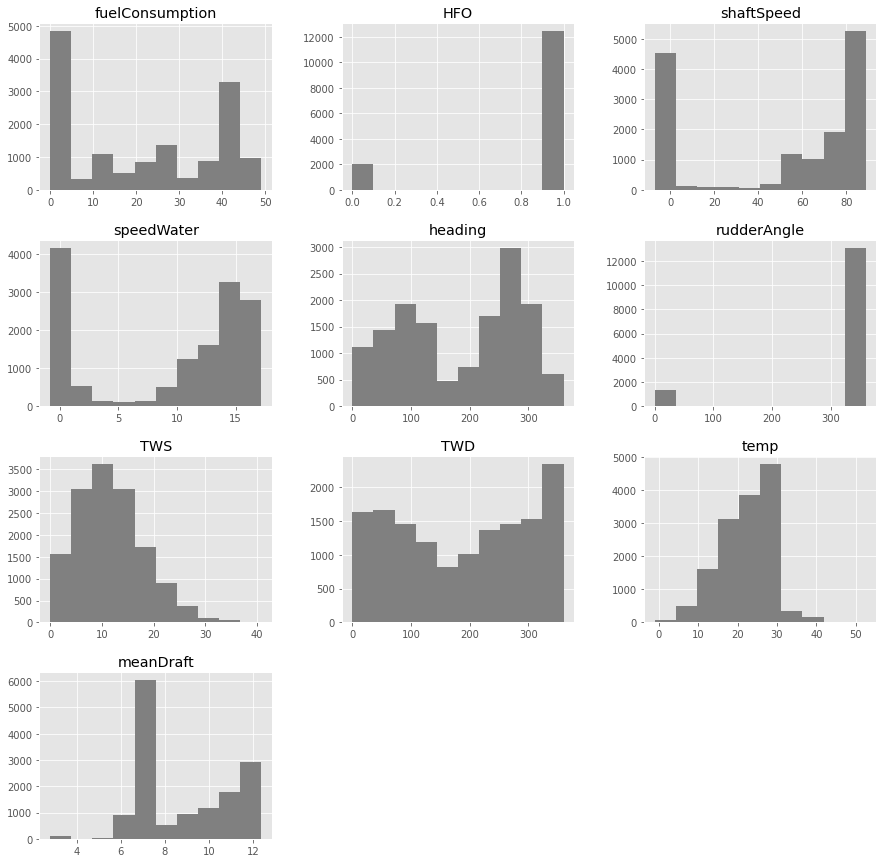

In [5]:
df.hist(color='grey');

In [6]:
# Split-out validation dataset
dataArray = df.values
X = dataArray[:, 1:10]
y = dataArray[:, 0]
validation_size = 0.2
seed = 1
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=validation_size, random_state=seed)

In [7]:
# Test options and evaluation metric
num_folds = 10
seed = 1
scoring = 'neg_mean_squared_error'

In [8]:
# Spot-Check Algorithms
models = []
models.append(('LR', LinearRegression())) 
models.append(('LASSO', Lasso())) 
models.append(('EN', ElasticNet())) 
models.append(('KNN', KNeighborsRegressor())) 
models.append(('CART', DecisionTreeRegressor())) 
models.append(('SVR', SVR()))

In [9]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=14)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LR: -27.941384 (1.342601)
LASSO: -29.445360 (1.591052)
EN: -29.486938 (1.597735)
KNN: -7.240375 (1.778332)
CART: -1.275456 (0.771561)
SVR: -44.857969 (3.340308)


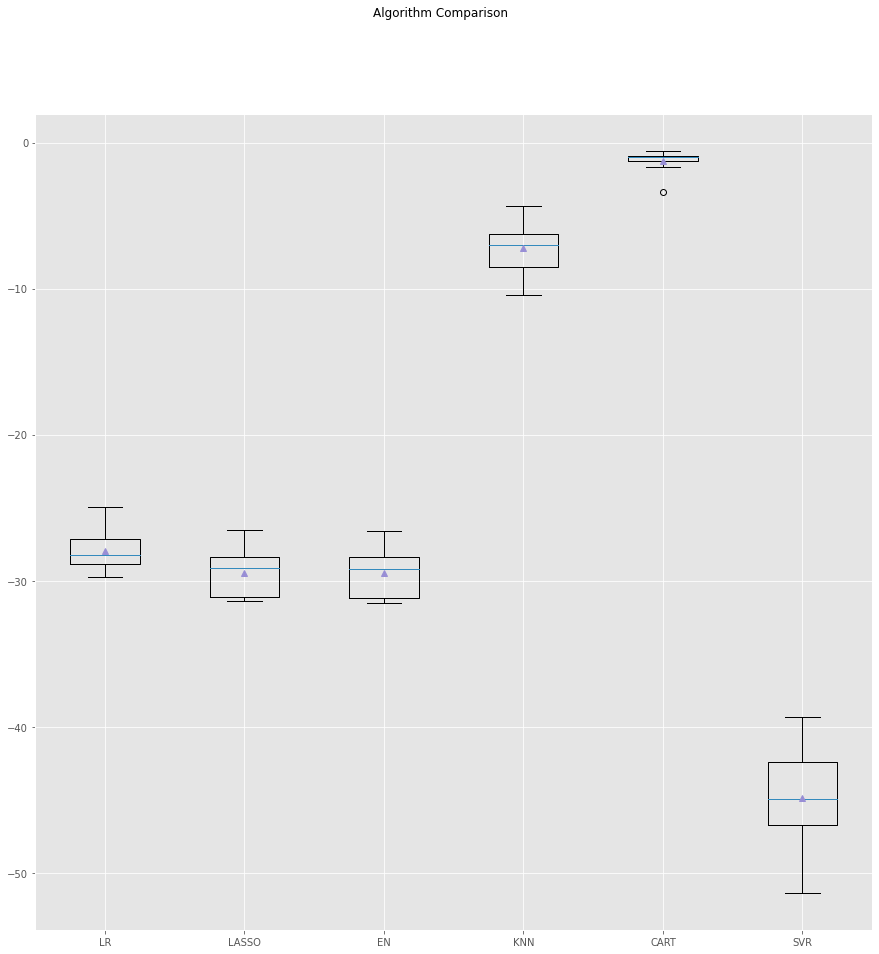

In [10]:
# Compare Algorithms
fig = plt.figure() 
fig.suptitle('Algorithm Comparison') 
ax = fig.add_subplot(111) 
plt.boxplot(results, showmeans=True) 
ax.set_xticklabels(names);

In [11]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())]))) 
results = []
names = []
for name, model in pipelines:
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=14)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

ScaledLR: -27.941384 (1.342601)
ScaledLASSO: -31.538014 (1.699536)
ScaledEN: -43.919407 (1.650595)
ScaledKNN: -4.842584 (0.768371)
ScaledCART: -1.151569 (0.518993)
ScaledSVR: -5.435082 (1.069214)


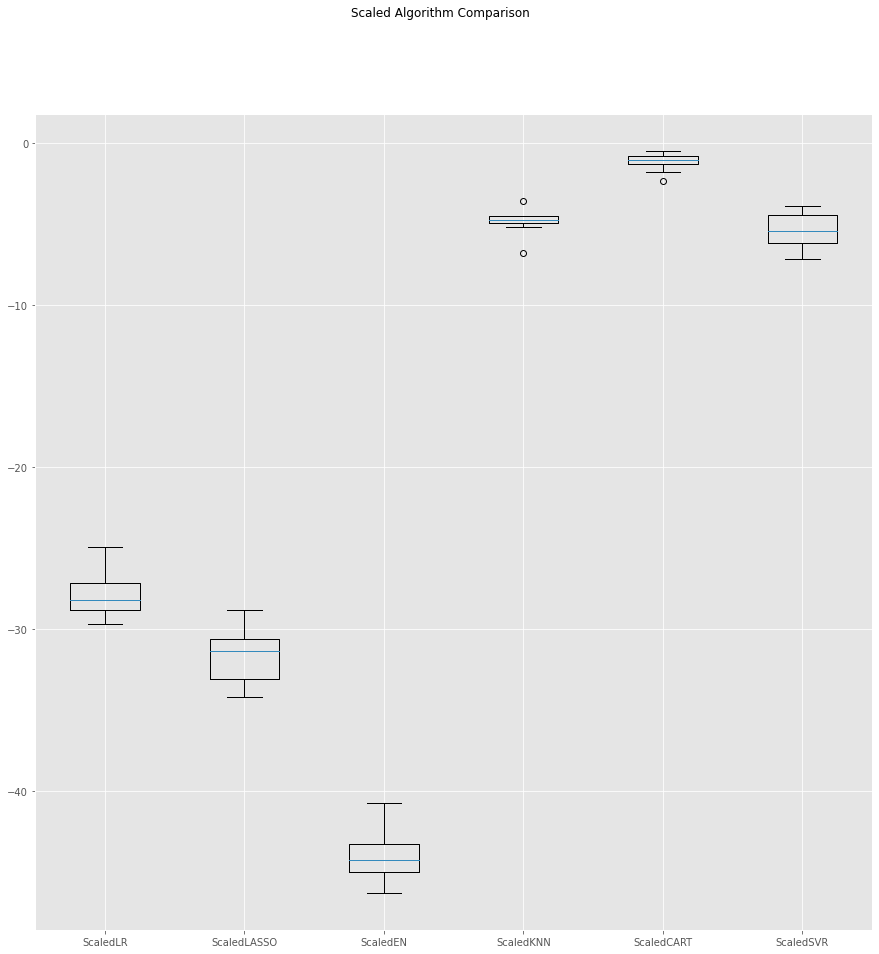

In [12]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Scaled Algorithm Comparison') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names);

**Ensembles**

In [189]:
ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators=10))]))) 
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor(n_estimators=10))])))
results = []
names = []
for name, model in ensembles:
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=14)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

ScaledAB: -13.310172 (2.157082)
ScaledGBM: -1.493645 (0.640060)
ScaledRF: -0.872915 (0.593135)
ScaledET: -0.793649 (0.570644)


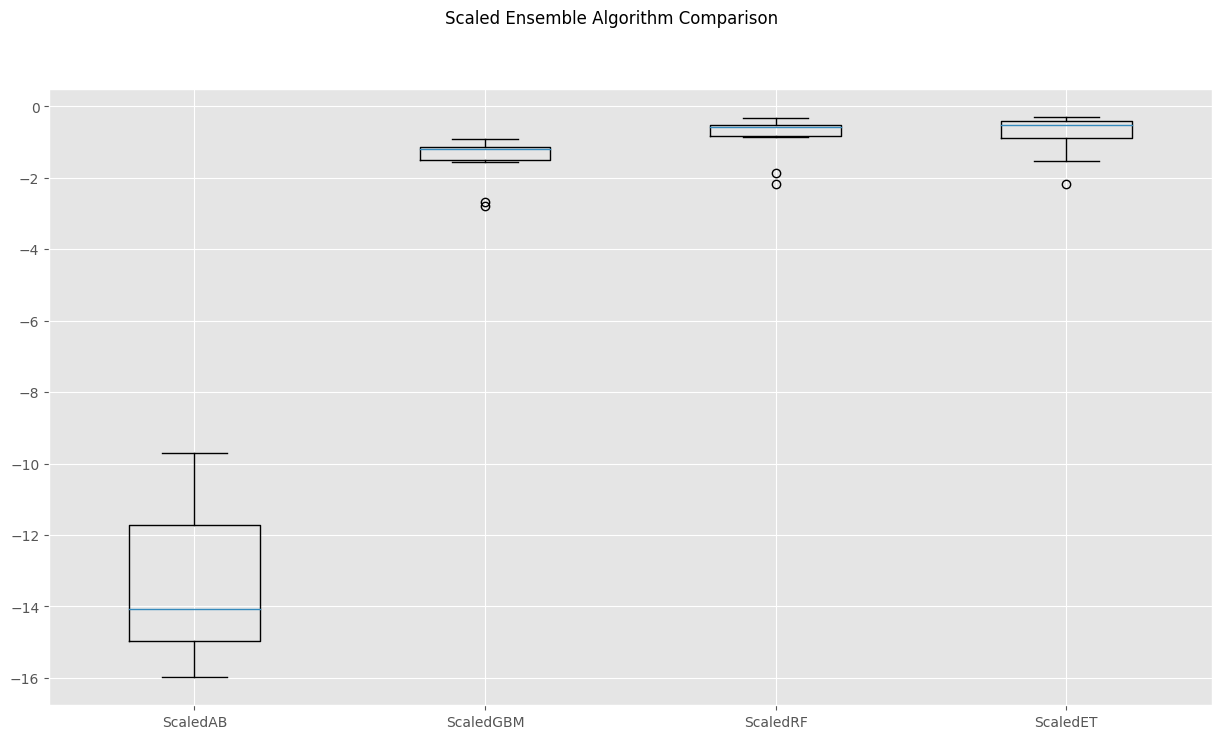

In [307]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Scaled Ensemble Algorithm Comparison') 
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names);

**Explore Number of trees and evaluate performance**

In [68]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [10, 50, 100, 300, 500, 1000, 1500, 2000]
    for n in n_trees:
        models[str(n)] = ExtraTreesRegressor(n_estimators=n)
    return models

models = get_models()

In [70]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

results = []
names = []
for name, model in models.items():
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, rescaledX, y_train, cv=kfold, scoring=scoring, n_jobs=14)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

10: -0.778322 (0.534783)
50: -0.733481 (0.578717)
100: -0.696632 (0.560490)
300: -0.700285 (0.565729)
500: -0.702478 (0.568475)
1000: -0.697541 (0.569422)
1500: -0.695968 (0.569477)
2000: -0.695244 (0.569802)


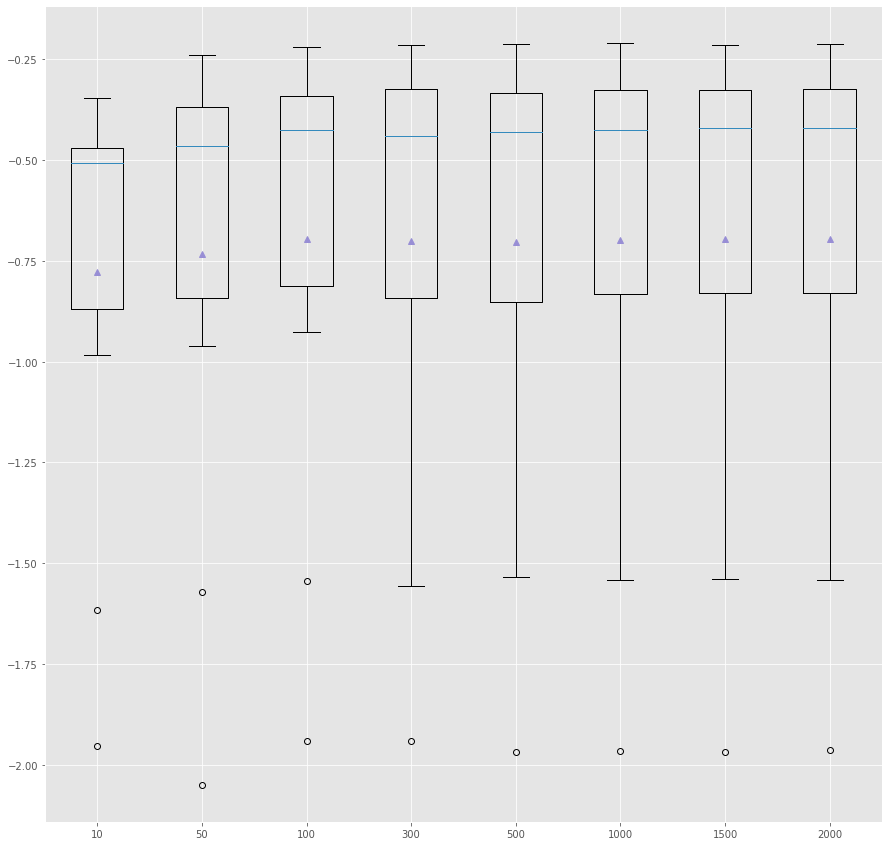

In [71]:
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True);

**Explore number of features**

In [78]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # Explore number of features to consider from 1 to 8
    for i in range(1, rescaledX.shape[1]):
        models[str(i)] = ExtraTreesRegressor(max_features=i)
    return models

models = get_models()

In [80]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

results = []
names = []
for name, model in models.items():
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, rescaledX, y_train, cv=kfold, scoring=scoring, n_jobs=14)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

1: -1.388912 (0.452068)
2: -0.881151 (0.513776)
3: -0.751489 (0.493655)
4: -0.714024 (0.521720)
5: -0.681891 (0.521088)
6: -0.687721 (0.535065)
7: -0.681116 (0.544570)
8: -0.693916 (0.553151)


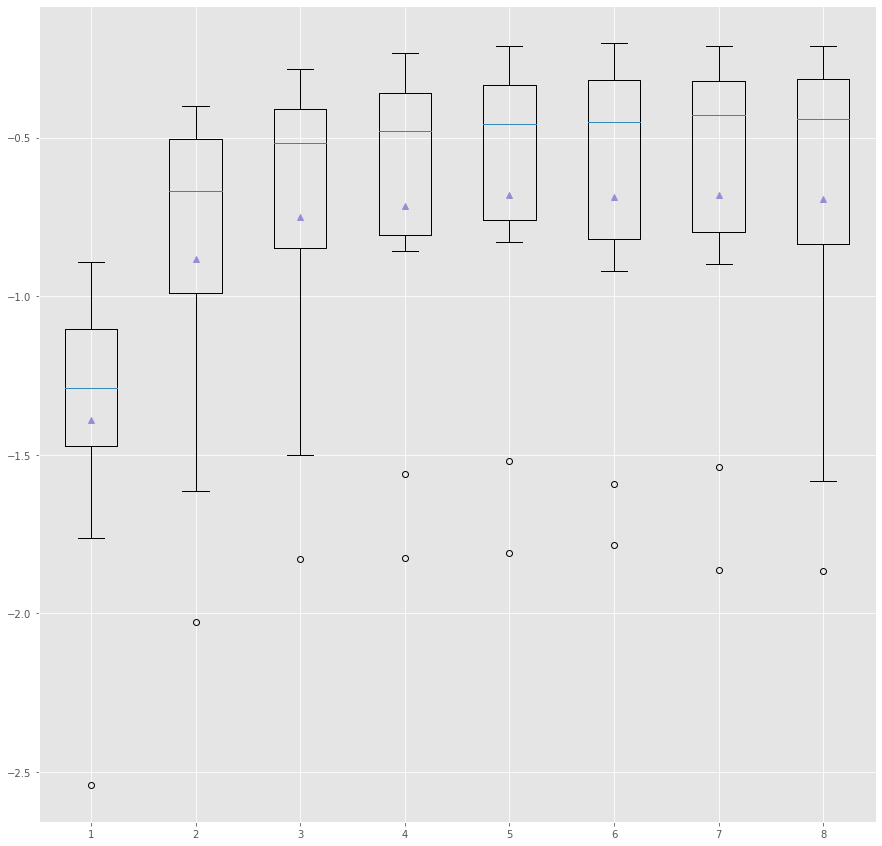

In [81]:
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True);

**Explore minimum samples per split**

In [84]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # Explore minimum samples per split from 2 to 8
    for i in range(2, 9):
        models[str(i)] = ExtraTreesRegressor(min_samples_split=i)
    return models

models = get_models()

In [86]:
results = []
names = []
for name, model in models.items():
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, rescaledX, y_train, cv=kfold, scoring=scoring, n_jobs=14)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

2: -0.702925 (0.551297)
3: -0.703060 (0.564032)
4: -0.708670 (0.571311)
5: -0.714684 (0.558174)
6: -0.719345 (0.580221)
7: -0.734003 (0.573240)
8: -0.723276 (0.561413)


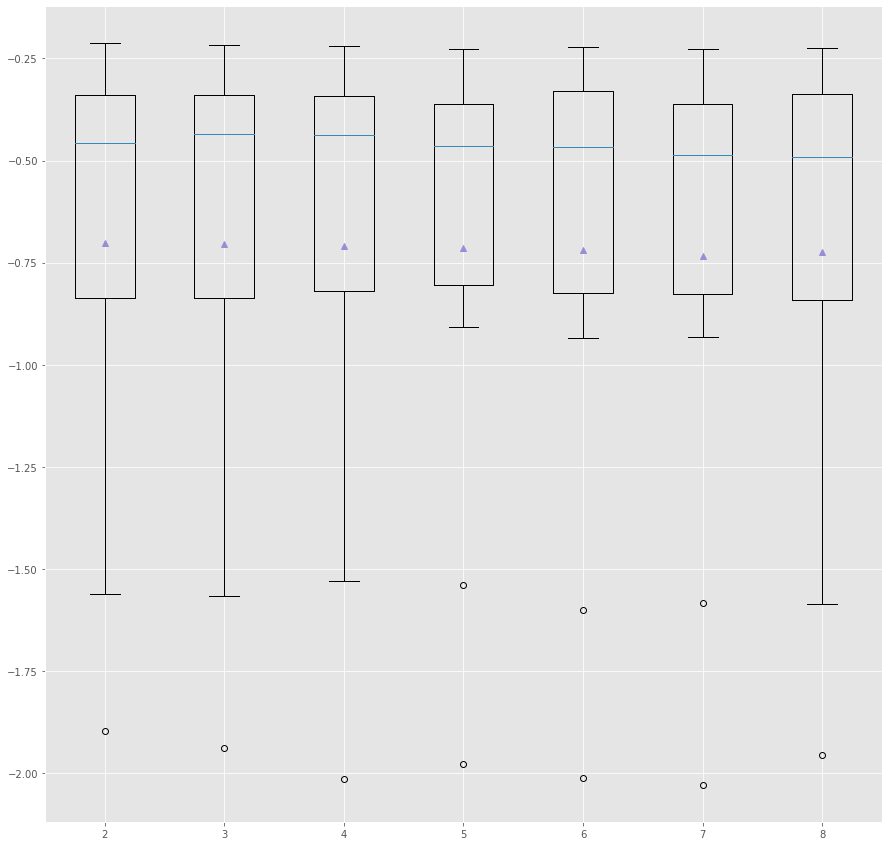

In [87]:
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True);

**Final Model**

In [88]:
# prepare the model
model = ExtraTreesRegressor(random_state=seed, 
                            n_estimators=100, 
                            max_features=5, 
                            min_samples_split=5, 
                            n_jobs=14)
model.fit(rescaledX, y_train)

ExtraTreesRegressor(max_features=5, min_samples_split=5, n_jobs=14,
                    random_state=1)

In [89]:
# transform the validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print(mean_squared_error(y_validation, predictions))

0.8534666956828244


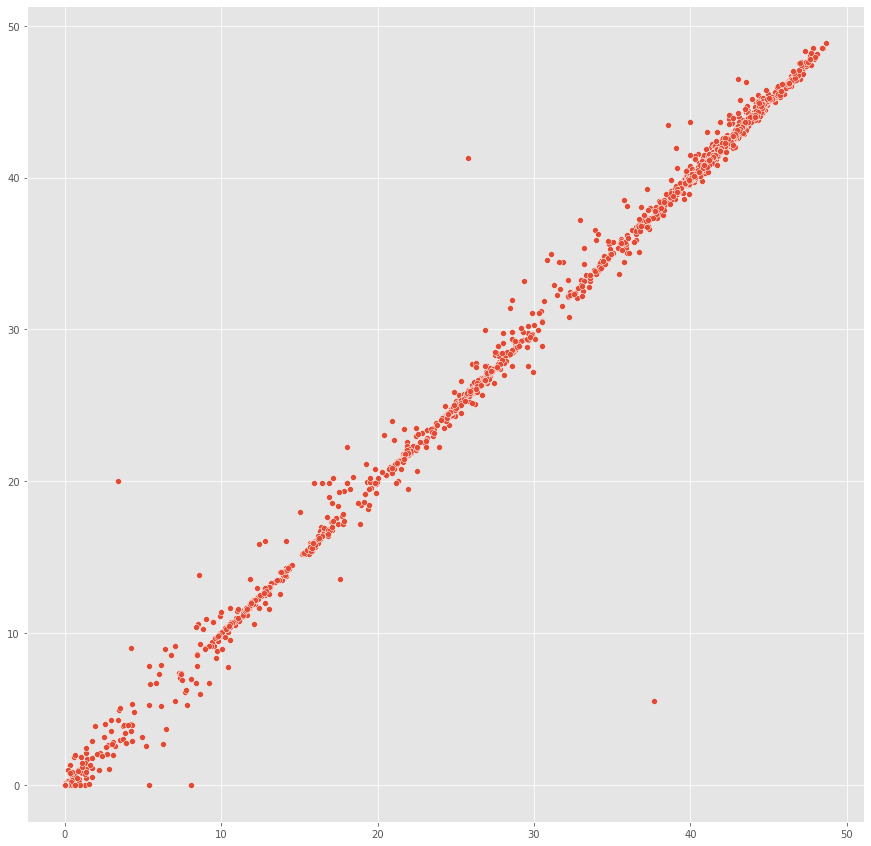

In [91]:
import seaborn as sns
sns.scatterplot(x = predictions, y = y_validation);